In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
df = pd.read_csv("BTFR_i_distances.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

di = df.set_index("PGC")

di.head()

,Vmod,DM_75,DMi_fid,F21,eF21,lgWmxi,elgWi,Qs,i***,logMs_i,logMs_W1
PGC,,,,,,,,,,,
4,4154,33.717026,33.371056,1.905,0.070000,2.189,0.011,5.0,15.12,9.220868,9.121780
16,5387,34.281429,34.634339,1.190,0.203539,2.515,0.025,5.0,13.58,10.197688,10.179541
55,4507,33.894131,33.642397,4.300,0.317899,2.260,0.025,5.0,15.22,9.182002,9.140623
68,7480,34.994202,34.803393,1.610,0.274314,2.390,0.043,5.0,14.52,9.945598,10.048651
70,6557,34.708220,35.205783,8.330,0.120000,2.636,0.003,5.0,13.24,10.439053,10.530258


In [4]:
df = pd.read_csv("BTFR_W1_distances.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

d1 = df.set_index("PGC")

d1.head()

,Vmod,DM_75,DM1_fid,F21,eF21,lgWmxi,elgWi,Qw,w1***,logMs_i,logMs_W1
PGC,,,,,,,,,,,
2,4786,34.024557,34.521953,4.730,0.805837,2.744,0.029,5.0,11.89,NaN,10.916793
4,4154,33.717026,33.485549,1.905,0.070000,2.189,0.011,4.0,16.07,9.220868,9.121780
12,6297,34.620362,35.001433,3.400,0.579492,2.606,0.021,5.0,13.59,NaN,10.475115
16,5387,34.281429,34.696530,1.190,0.203539,2.515,0.025,5.0,13.99,10.197688,10.179541
55,4507,33.894131,33.660352,4.300,0.317899,2.260,0.025,4.0,16.20,9.182002,9.140623


In [5]:
df = di.join(d1, how='outer', lsuffix='_i', rsuffix='_w1')

commons = ['Vmod', 'lgWmxi', 'elgWi', 'F21', 'eF21', 'DM_75', 'logMs_i', 'logMs_W1']
for col in commons:
    df[col] = df.apply(lambda X: X[col+"_i"] if ~np.isnan(X[col+"_i"]) else X[col+"_w1"], axis=1)

df = df[commons+["DMi_fid", "DM1_fid", 'i***', 'w1***', "Qs", "Qw"]]

df.head()

,Vmod,lgWmxi,elgWi,F21,eF21,DM_75,logMs_i,logMs_W1,DMi_fid,DM1_fid,i***,w1***,Qs,Qw
PGC,,,,,,,,,,,,,,
2,4786.0,2.744,0.029,4.730,0.805837,34.024557,NaN,10.916793,NaN,34.521953,NaN,11.89,NaN,5.0
4,4154.0,2.189,0.011,1.905,0.070000,33.717026,9.220868,9.121780,33.371056,33.485549,15.12,16.07,5.0,4.0
12,6297.0,2.606,0.021,3.400,0.579492,34.620362,NaN,10.475115,NaN,35.001433,NaN,13.59,NaN,5.0
16,5387.0,2.515,0.025,1.190,0.203539,34.281429,10.197688,10.179541,34.634339,34.696530,13.58,13.99,5.0,5.0
55,4507.0,2.260,0.025,4.300,0.317899,33.894131,9.182002,9.140623,33.642397,33.660352,15.22,16.20,5.0,4.0


In [6]:
old = pd.read_csv("../calibrators/DMs_EDD.csv.test", sep='|')

for col in old.columns:
    newcol = col.strip()
    old.rename(columns={col:newcol}, inplace=True)
old = old.set_index("pgc")

oldCols = ["P0", "ggg", "rrr", "zzz"]
for col in oldCols:
    old[col] = old[col].apply(lambda x: np.float(x))


df = df.join(old[oldCols], how='left')

df.head()

,Vmod,lgWmxi,elgWi,F21,eF21,DM_75,logMs_i,logMs_W1,DMi_fid,DM1_fid,i***,w1***,Qs,Qw,P0,ggg,rrr,zzz
PGC,,,,,,,,,,,,,,,,,,
2,4786.0,2.744,0.029,4.730,0.805837,34.024557,NaN,10.916793,NaN,34.521953,NaN,11.89,NaN,5.0,2.02,0.00,0.00,0.00
4,4154.0,2.189,0.011,1.905,0.070000,33.717026,9.220868,9.121780,33.371056,33.485549,15.12,16.07,5.0,4.0,-2.75,15.59,15.33,15.07
12,6297.0,2.606,0.021,3.400,0.579492,34.620362,NaN,10.475115,NaN,35.001433,NaN,13.59,NaN,5.0,0.56,0.00,0.00,0.00
16,5387.0,2.515,0.025,1.190,0.203539,34.281429,10.197688,10.179541,34.634339,34.696530,13.58,13.99,5.0,5.0,0.92,14.36,13.86,13.40
55,4507.0,2.260,0.025,4.300,0.317899,33.894131,9.182002,9.140623,33.642397,33.660352,15.22,16.20,5.0,4.0,-2.83,15.53,15.32,15.17


In [7]:
len(df)

10736

In [8]:
cf3 = pd.read_csv("../calibrators/cf3.csv", sep='|')

for col in cf3.columns:
    newcol = col.strip()
    cf3.rename(columns={col:newcol}, inplace=True)

cf3.set_index('PGC', inplace=True)

cf3['DM_cf3'] = cf3['DM']
cf3 = cf3[['DM_cf3']]

cf3.head()

/home/ehsan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,DM_cf3
PGC,
4,33.52
27,35.89
40,35.34
51,36.91
55,34.34


In [9]:
df34 = df.join(cf3, how='inner')

df34.head()

,Vmod,lgWmxi,elgWi,F21,eF21,DM_75,logMs_i,logMs_W1,DMi_fid,DM1_fid,i***,w1***,Qs,Qw,P0,ggg,rrr,zzz,DM_cf3
PGC,,,,,,,,,,,,,,,,,,,
4,4154.0,2.189,0.011,1.905,0.070000,33.717026,9.220868,9.121780,33.371056,33.485549,15.12,16.07,5.0,4.0,-2.75,15.59,15.33,15.07,33.52
55,4507.0,2.260,0.025,4.300,0.317899,33.894131,9.182002,9.140623,33.642397,33.660352,15.22,16.20,5.0,4.0,-2.83,15.53,15.32,15.17,34.34
70,6557.0,2.636,0.003,8.330,0.120000,34.708220,10.439053,10.530258,35.205783,35.066395,13.24,13.54,5.0,5.0,-0.74,13.87,13.46,13.02,35.35
76,6698.0,2.624,0.013,4.425,0.110000,34.754419,10.702808,10.672738,34.699504,34.803306,12.91,13.23,5.0,5.0,0.75,13.80,13.21,12.73,34.95
94,4037.0,2.274,0.032,3.610,0.615244,33.654987,NaN,9.188965,NaN,33.716815,NaN,15.84,NaN,4.0,-2.91,0.00,0.00,0.00,34.15


(<AxesSubplot:label='0267afa5-829d-4058-af4f-63382a2bdf47'>,
 <AxesSubplot:label='0e77cdce-a4e4-4a03-84c7-7ceb45f0e7e4'>)

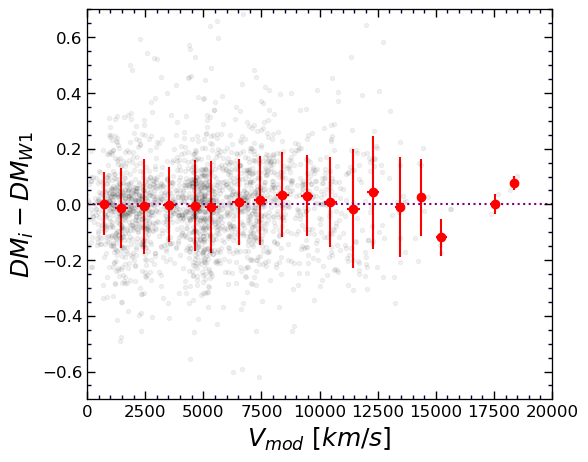

In [10]:
dff = df[(df.Qs>2)&(df.Qw>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vmod.values
Y = dff.DMi_fid.values-dff.DM1_fid.values
# Y = (dff.DM_75.values-dff.DMi_fid.values)/5.


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{i}-DM_{W1}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.7,0.7), fontsize=12)

# ax.set_title("BTFR: W1-band")


In [11]:
PGC_outlier_1 = [    356,    1286,    1553,    2080,    2266,    2768,    3084,
          3174,    3235,    3717,    3763,    5043,    6054,    6438,
          6966,    6982,    9399,   15460,   21673,   22381,   23355,
         27640,   30358,   32707,   35942,   36349,   36466,   42938,
         43726,   45887,   50012,   51450,   53728,   66948,   67511,
         69016,   83427,   84490,   90431,   90844,   91252,  142838,
        142840,  169737, 4310833, 5057394, 5057398]

PGC_outlier_2 = [   2712,    3081,    3133,    3247,    4387,    6889,    9134,
         36778,   53291,   70708,   71795,   85607,  138562,  142824,
        169989,  170138, 1056132, 1129847, 5076801]


(<AxesSubplot:label='14b82436-b9c6-49f3-88e9-5efad69a3bf8'>,
 <AxesSubplot:label='85a57771-5067-49af-b3de-f4c182ca738e'>)

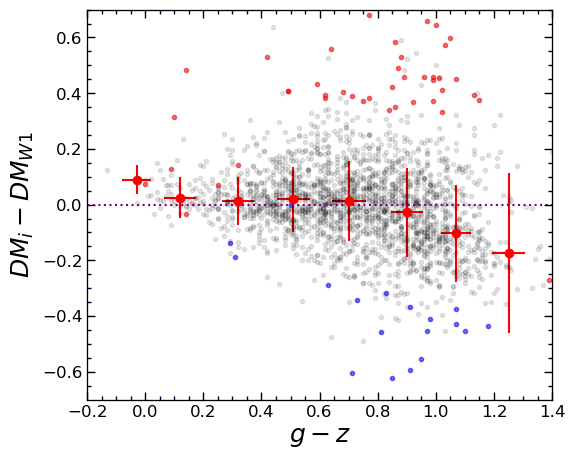

In [12]:
dff = df[(df.Qs>2)&(df.Qw>2)&(df.lgWmxi>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.ggg.values-dff.zzz.values
Y = dff.DMi_fid.values-dff.DM1_fid.values
# Y = (dff.DM_75.values-dff.DMi_fid.values)/5.
ID = dff.index.values

ax.plot(X, Y, 'k.', alpha=0.1)

X0 = []
Y0 = []
for i in range(len(X)):
    if ID[i] in PGC_outlier_1:
        ax.plot([X[i]], [Y[i]], 'r.', alpha=0.5)
    else:
        X0.append(X[i])
        Y0.append(Y[i])
        
        
for i in range(len(X)):
    if ID[i] in PGC_outlier_2:
        ax.plot([X[i]], [Y[i]], 'b.', alpha=0.5)
    else:
        X0.append(X[i])
        Y0.append(Y[i])        

X = X0
Y = Y0

for i in np.arange(-.2,1.4,0.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$g-z$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{i}-DM_{W1}$', fontsize=18)

ax.plot([-1.5, 2], [0,0], ':', color='purple')

set_axes(ax, (-.2,1.4), (-0.7,0.7), fontsize=12)



(<AxesSubplot:label='605997d7-c78a-4ead-babd-0544eca7c82a'>,
 <AxesSubplot:label='e7085e97-a783-415f-bf3e-0ef509c7fad0'>)

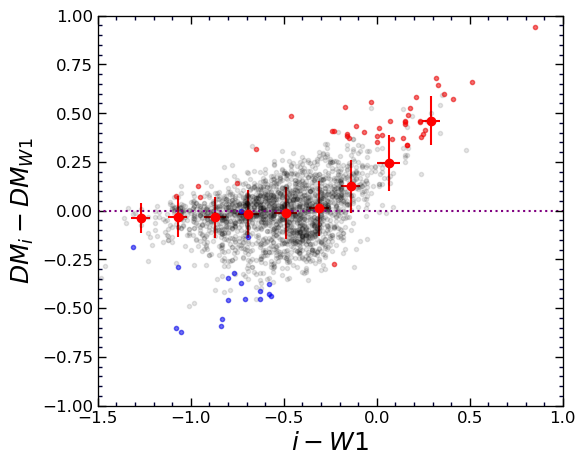

In [13]:
dff = df[(df.Qs>2)&(df.Qw>2)&(df.lgWmxi>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff["i***"].values-dff["w1***"].values
Y = dff.DMi_fid.values-dff.DM1_fid.values
# Y = (dff.DM_75.values-dff.DMi_fid.values)/5.
ID = dff.index.values

ax.plot(X, Y, 'k.', alpha=0.1)

X0 = []
Y0 = []
for i in range(len(X)):
    if ID[i] in PGC_outlier_1:
        ax.plot([X[i]], [Y[i]]
                , 'r.', alpha=0.5)
    else:
        X0.append(X[i])
        Y0.append(Y[i])
        
        
for i in range(len(X)):
    if ID[i] in PGC_outlier_2:
        ax.plot([X[i]], [Y[i]], 'b.', alpha=0.5)
    else:
        X0.append(X[i])
        Y0.append(Y[i])        

X = X0
Y = Y0
    
for i in np.arange(-1.4,0.4,0.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$i-W1$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{i}-DM_{W1}$', fontsize=18)

ax.plot([-1.5, 1.2], [0,0], ':', color='purple')

set_axes(ax, (-1.5,1), (-1,1), fontsize=12)



(<AxesSubplot:label='ef7f3d04-6245-43f0-b663-c73fc837de29'>,
 <AxesSubplot:label='8c46023a-1209-40f6-9f5c-c48918bad559'>)

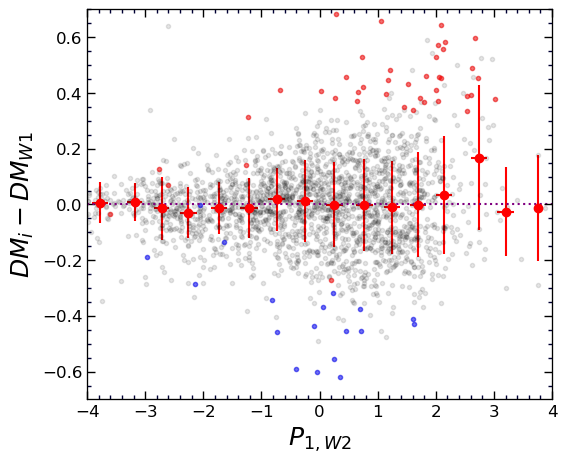

In [14]:
dff = df[(df.Qs>2)&(df.Qw>2)&(df.lgWmxi>0)]###&(df['i***']-df["w1***"]<-0.4)
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.P0.values
Y = dff.DMi_fid.values-dff.DM1_fid.values
# Y = (dff.DM_75.values-dff.DMi_fid.values)/5.


ID = dff.index.values

ax.plot(X, Y, 'k.', alpha=0.1)

X0 = []
Y0 = []
for i in range(len(X)):
    if ID[i] in PGC_outlier_1:
        ax.plot([X[i]], [Y[i]]
                , 'r.', alpha=0.5)
    else:
        X0.append(X[i])
        Y0.append(Y[i])
        
        
for i in range(len(X)):
    if ID[i] in PGC_outlier_2:
        ax.plot([X[i]], [Y[i]], 'b.', alpha=0.5)
    else:
        X0.append(X[i])
        Y0.append(Y[i])        

X = X0
Y = Y0

for i in np.arange(-4,4,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$P_{1,W2}$', fontsize=18)
ax.set_ylabel(r'$DM_{i}-DM_{W1}$', fontsize=18)

ax.plot([-4,4], [0,0], ':', color='purple')

set_axes(ax, (-4,4), (-0.7,0.7), fontsize=12)



(<AxesSubplot:label='1e6e1bfd-867e-4b71-a25b-724789ccc09a'>,
 <AxesSubplot:label='c4ad37f3-7026-493a-92c9-f61a0f24bba0'>)

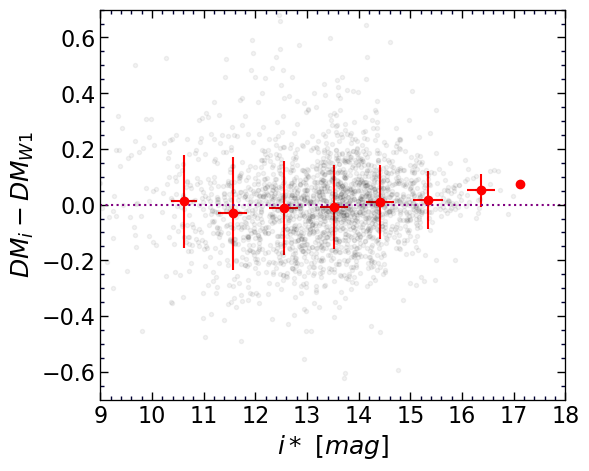

In [15]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff['i***'].values
Y = dff.DMi_fid.values-dff.DM1_fid.values

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$i* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$DM_{i}-DM_{W1}$', fontsize=18)

ax.plot([9,18], [0,0], ':', color='purple')

set_axes(ax, (9,18), (-0.7,0.7))

(<AxesSubplot:label='d97ea69c-d630-43ac-8353-3106e1e0d4fe'>,
 <AxesSubplot:label='29c46b23-4b21-443d-9dbd-5e4414896151'>)

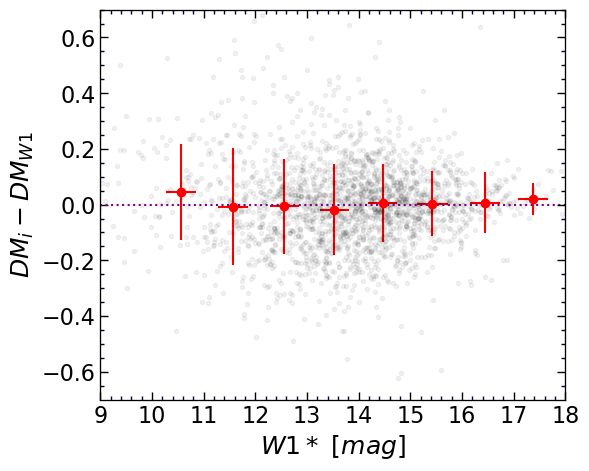

In [16]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff['w1***'].values
Y = dff.DMi_fid.values-dff.DM1_fid.values

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$W1* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$DM_{i}-DM_{W1}$', fontsize=18)

ax.plot([9,18], [0,0], ':', color='purple')

set_axes(ax, (9,18), (-0.7,0.7))

(<AxesSubplot:label='285ef83a-148b-4e2f-8c8c-b0ab53f3966a'>,
 <AxesSubplot:label='ac2ce605-2126-478d-80ff-0151bd315903'>)

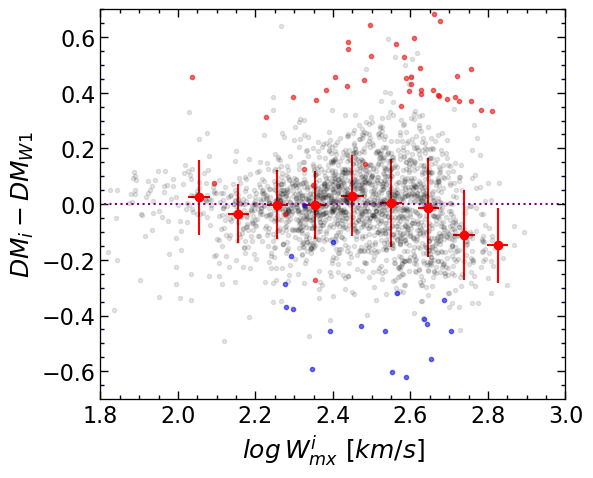

In [17]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.lgWmxi.values
Y = dff.DMi_fid.values-dff.DM1_fid.values
ID = dff.index.values

ax.plot(X, Y, 'k.', alpha=0.1)

X0 = []
Y0 = []
for i in range(len(X)):
    if ID[i] in PGC_outlier_1:
        ax.plot([X[i]], [Y[i]]
                , 'r.', alpha=0.5)
    else:
        X0.append(X[i])
        Y0.append(Y[i])
        
        
for i in range(len(X)):
    if ID[i] in PGC_outlier_2:
        ax.plot([X[i]], [Y[i]], 'b.', alpha=0.5)
    else:
        X0.append(X[i])
        Y0.append(Y[i])        

X = X0
Y = Y0



for i in np.arange(2,3,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18)
ax.set_ylabel(r'$DM_{i} - DM_{W1}$', fontsize=18)

ax.plot([-10,10], [0,0], ':', color='purple')

set_axes(ax, (1.8,3), (-0.7,0.7))

# ax.set_title("BTFR: W1-band")

In [18]:
dff["delta"] = dff.DMi_fid.values-dff.DM1_fid.values

dff[(dff.Vmod<2500)&(dff.delta<0.1)]

<ipython-input-18-ffef637fabca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff["delta"] = dff.DMi_fid.values-dff.DM1_fid.values


,Vmod,lgWmxi,elgWi,F21,eF21,DM_75,logMs_i,logMs_W1,DMi_fid,DM1_fid,i***,w1***,Qs,Qw,P0,ggg,rrr,zzz,delta
PGC,,,,,,,,,,,,,,,,,,,
279,1970.0,2.612,0.005,14.455,0.13,32.097025,10.557278,10.597780,32.336262,32.274847,10.66,10.76,5.0,5.0,1.63000,11.59,10.98,10.53,0.061415
889,502.0,1.963,0.009,13.950,0.06,29.128212,7.653721,7.614255,29.626006,29.581359,13.85,15.25,4.0,4.0,-4.99000,13.77,13.94,14.16,0.044647
924,1345.0,2.187,0.011,3.665,0.08,31.268305,8.966731,8.822292,31.775400,32.005237,13.47,14.37,5.0,5.0,-1.88000,14.09,13.69,13.32,-0.229838
1525,495.0,2.301,0.004,44.485,0.10,29.097720,8.681145,8.558058,30.712073,30.829174,11.85,12.86,5.0,4.0,-2.38104,12.32,12.04,11.84,-0.117101
1750,993.0,2.035,0.025,6.870,0.06,30.609440,8.393833,8.326746,30.698094,30.716606,14.08,14.95,5.0,5.0,-2.47000,14.55,14.23,14.11,-0.018511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365234,2149.0,2.070,0.008,2.420,0.07,32.285876,8.093629,8.037320,32.623018,32.605561,16.30,17.35,5.0,3.0,-3.87000,16.58,16.43,16.53,0.017457
1419134,2403.0,1.824,0.134,0.620,0.05,32.528463,8.146740,8.122355,31.659149,31.607868,16.29,17.38,5.0,3.0,-3.84000,16.46,16.41,16.23,0.051281
4017882,1989.0,1.843,0.120,0.855,0.08,32.117868,7.846069,7.810117,31.710121,31.658776,16.74,17.75,4.0,3.0,-4.70000,17.01,16.93,16.86,0.051344


<ipython-input-19-c2e869075a20>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dff = df34[(df.Qs>2)]


(<AxesSubplot:label='589df4bd-8170-409c-83f1-2f1218b14b31'>,
 <AxesSubplot:label='c842a988-90ba-432d-8c3d-084dd7f234d7'>)

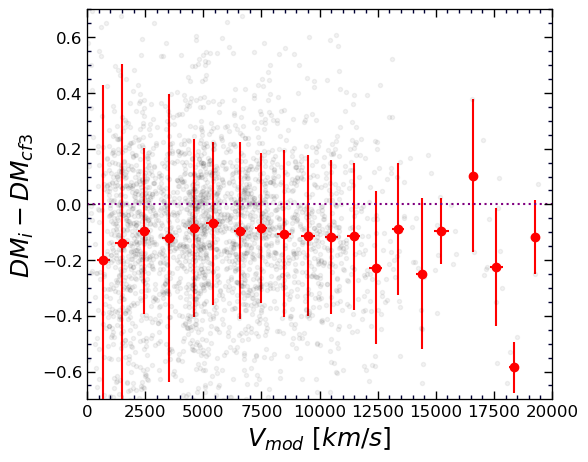

In [19]:
dff = df34[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vmod.values
Y = dff.DMi_fid.values-dff.DM_cf3.values
# Y = (dff.DM_75.values-dff.DMi_fid.values)/5.


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{i}-DM_{cf3}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.7,0.7), fontsize=12)

# ax.set_title("BTFR: W1-band")


<ipython-input-20-596cc0b3f535>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dff = df34[(df.Qw>2)]


(<AxesSubplot:label='9f7b98a0-6a0a-450b-9619-3deb5462d51e'>,
 <AxesSubplot:label='5dd8a123-2a59-403b-8d7f-96170cd0020d'>)

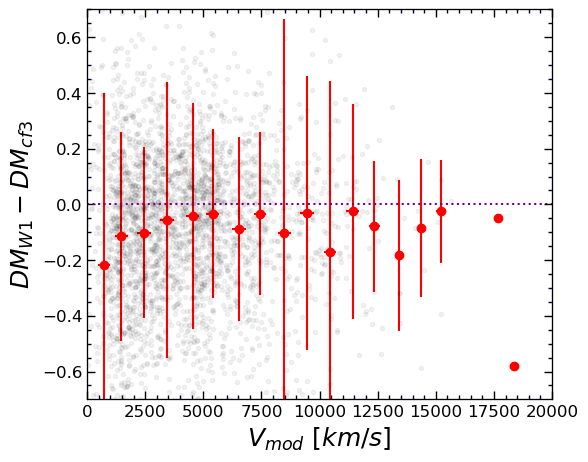

In [20]:
dff = df34[(df.Qw>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vmod.values
Y = dff.DM1_fid.values-dff.DM_cf3.values
# Y = (dff.DM_75.values-dff.DMi_fid.values)/5.


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{W1}-DM_{cf3}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.7,0.7), fontsize=12)

# ax.set_title("BTFR: W1-band")


In [21]:
from astropy.table import Table, Column

df_ = df.reset_index()

df_.to_csv('BTFR_CF4_Dist_bar.csv', sep='|', index=False)


table   = np.genfromtxt('BTFR_CF4_Dist_bar.csv' , delimiter='|', 
                        filling_values=-100000, names=True, dtype=None, encoding=None)

colnames = table.dtype.names

## table is a structured array
myTable = {}
for name in table.dtype.names:
    myTable[name] = table[name]
table = myTable
## table is now a dictionary

myTable = Table()

for key in colnames:
    if key in ["PGC"]:
        myTable.add_column(Column(data=table[key], name=key))
    elif key in ["F21", "eF21", "lgWmxi", "elgWi"]:
        myTable.add_column(Column(data=table[key], name=key, format='%0.3f'))    
    elif key in ["Vls", 'V3k', 'Vmod', "Qs", "Qw"]:
        myTable.add_column(Column(data=table[key], name=key, dtype=np.dtype(int)))
    else:
        myTable.add_column(Column(data=table[key], name=key, format='%0.2f'))

## to be used on EDD
myTable.write('BTFR_CF4_Dist_bar', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True)
## cf4btfdistances

In [22]:
df_.head()

,PGC,Vmod,lgWmxi,elgWi,F21,eF21,DM_75,logMs_i,logMs_W1,DMi_fid,DM1_fid,i***,w1***,Qs,Qw,P0,ggg,rrr,zzz
0,2,4786.0,2.744,0.029,4.730,0.805837,34.024557,NaN,10.916793,NaN,34.521953,NaN,11.89,NaN,5.0,2.02,0.00,0.00,0.00
1,4,4154.0,2.189,0.011,1.905,0.070000,33.717026,9.220868,9.121780,33.371056,33.485549,15.12,16.07,5.0,4.0,-2.75,15.59,15.33,15.07
2,12,6297.0,2.606,0.021,3.400,0.579492,34.620362,NaN,10.475115,NaN,35.001433,NaN,13.59,NaN,5.0,0.56,0.00,0.00,0.00
3,16,5387.0,2.515,0.025,1.190,0.203539,34.281429,10.197688,10.179541,34.634339,34.696530,13.58,13.99,5.0,5.0,0.92,14.36,13.86,13.40
4,55,4507.0,2.260,0.025,4.300,0.317899,33.894131,9.182002,9.140623,33.642397,33.660352,15.22,16.20,5.0,4.0,-2.83,15.53,15.32,15.17


(<AxesSubplot:label='5e269112-04ca-422d-aa7a-976adb6d13de'>,
 <AxesSubplot:label='6799f39e-379f-42e0-bf5e-ac2e8cffbe08'>)

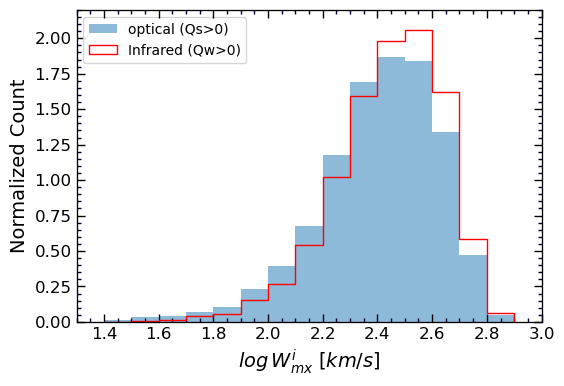

In [23]:
fig = py.figure(figsize=(5,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

bins = np.arange(1.4,3,0.1)

ax.hist(df_[df_.Qs>0].lgWmxi, bins=bins, alpha=0.5, density=True, label='optical (Qs>0)')
ax.hist(df_[df_.Qw>0].lgWmxi, bins=bins, alpha=1, density=True, histtype='step', color='red', label='Infrared (Qw>0)')

ax.legend(loc=2)

ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=14)
ax.set_ylabel('Normalized Count', fontsize=14)

set_axes(ax, (1.3,3), (0,2.2), fontsize=12)
